## Exercise 1: Planning a telescope observation <a class="anchor" id="five"></a>

In [ ]:
!pip install astroML
!pip install dynesty
!pip install emcee
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 6.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 5.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from astropy.visualization.hist import hist as fancyhist
import statistics
from astroML import stats as astroMLstats
import emcee
import corner
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [ ]:
np.random.seed(16)
N=10**4

number_of_days = np.arange(1,N+1,1)
sunny_days = np.zeros(N)
rain = True #start with a rainy day

for i in range(N-1):
  p = np.random.uniform() #randon number from uniform dist [0,1]
  if rain == True: #if the day is rainy
    if p <= 0.5 : #given probability of 50% for sunny day tomorrow
      sunny_days[i+1] = 1 #the day tommorow will be sunny
      rain = False
  else: #if the day is sunny
    if p <= 0.9: #given probability of 90% for sunny day tomorrow
      sunny_days[i+1] = 1
    else:
      rain=True #changes for raniy day

print(f'The avarege number of sunny days is: {sum(sunny_days)/N}')


The avarege number of sunny days is: 0.8241


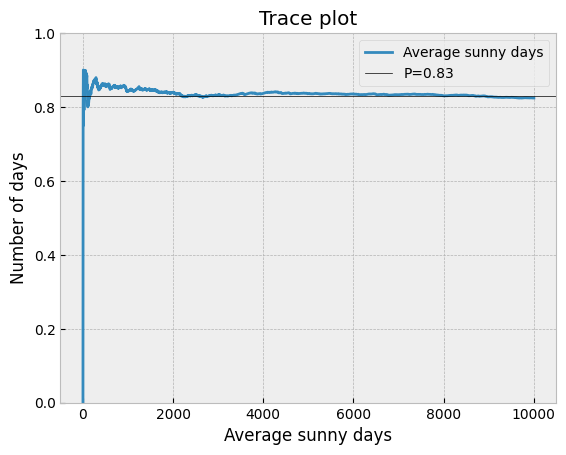

In [ ]:
cum_sum = np.cumsum(sunny_days)/number_of_days

plt.style.use('bmh')
plt.plot(number_of_days, cum_sum, label='Average sunny days')
plt.ylim([0,1])
plt.axhline(0.83, color='black', linewidth = 0.5, label='P=0.83')
plt.legend()
plt.title('Trace plot')
plt.xlabel('Average sunny days')
plt.ylabel('Number of days')
plt.show()

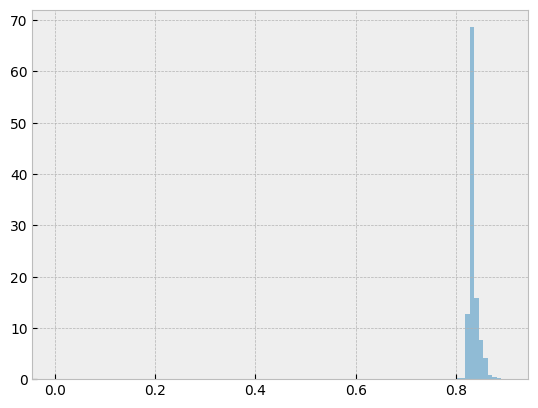

In [ ]:
_ = plt.hist(cum_sum, bins=100, alpha=0.5, density=True, histtype='stepfilled')


Looking on the  traceplot of the samples it is clear that  in the early steps of the chain process is not stationary. Also we can see a long tail in the histogram. There is a burn-in phase that needs to be discarded, I'll discard the first 2000 steps. Now, the process is stationary. The chain statistics look the same no matter which chunk we look and the histogram looks better without the tail.

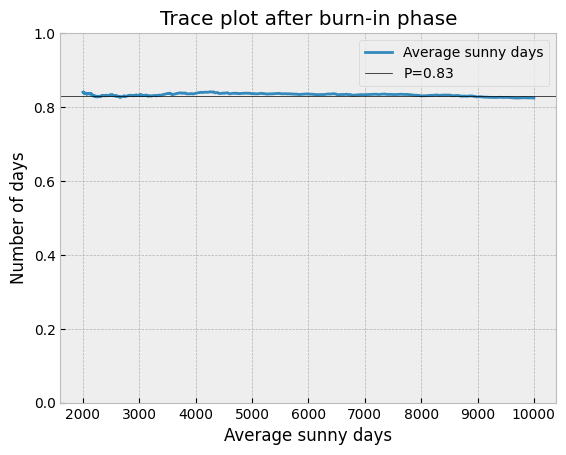

In [ ]:
burn_in = 2000 #the number of burn-in steps

plt.style.use('bmh')
plt.plot(number_of_days[burn_in:], cum_sum[burn_in:], label='Average sunny days')
plt.ylim([0,1])
plt.axhline(0.83, color='black', linewidth = 0.5, label='P=0.83')
plt.legend()
plt.title('Trace plot after burn-in phase')
plt.xlabel('Average sunny days')
plt.ylabel('Number of days')
plt.show()

In [ ]:
mean = statistics.mean(cum_sum[burn_in:])#mean value after burn-in
median = statistics.median(cum_sum[burn_in:])#meadian value after burn-in

print(f'The mean probability for sunny day is {round(mean,4)} .')
print(f'The median probability for sunny day is {round(median,4)} .')

The mean probability for sunny day is 0.8326 .
The median probability for sunny day is 0.8334 .


The most likelihood vale is 0.8335


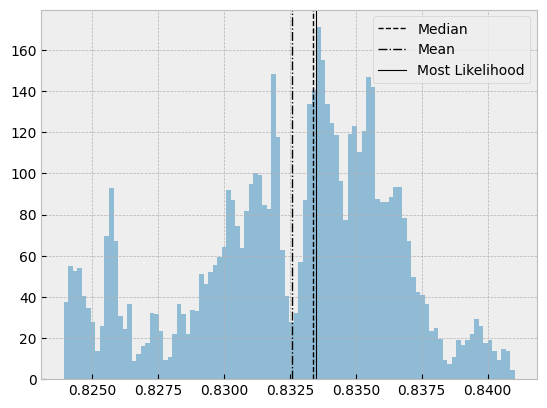

In [ ]:
h = plt.hist(cum_sum[burn_in:], bins=100, alpha=0.5, density=True, histtype='stepfilled')

most_likelihood = h[1][np.argsort(h[0])[-1]] #the most likelihood value after burn-in
print(f'The most likelihood vale is {round(most_likelihood,4)}')


plt.axvline(median, label='Median', color='black', ls='--', linewidth=1)
plt.axvline(mean, label='Mean',color='black', ls='-.', linewidth=1)
plt.axvline(most_likelihood, label='Most Likelihood', color='black', ls='-', linewidth=0.8)
plt.legend()


We can estimate the error using $\sigma_G$:

In [ ]:
SigmaG = astroMLstats.sigmaG(h[1])
print(f'SigmaG= {SigmaG}')

SigmaG= 0.00633852805707102


Or just using the simple percentile of the data :

In [ ]:
sigma = np.percentile(cum_sum[burn_in:],[2.5,16,50,84,97.5])
print(sigma)

[0.82445202 0.82871803 0.83338245 0.83619074 0.8395033 ]


The most likelihood vale is 0.8332 with sigma=0.0144 for 500 burn-in steps.
The most likelihood vale is 0.8333 with sigma=0.0112 for 1000 burn-in steps.
The most likelihood vale is 0.8335 with sigma=0.0063 for 2000 burn-in steps.
The most likelihood vale is 0.8335 with sigma=0.0048 for 5000 burn-in steps.


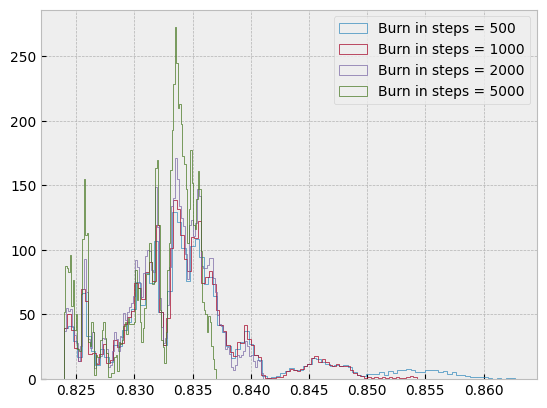

In [ ]:
initial_points = [500, 1000, 2000, 5000] #the number of points we want to discard
for initial in initial_points:
  h = plt.hist(cum_sum[initial:], bins=100, alpha=1, density=True, histtype='step', label=f'Burn in steps = {initial}')
  most_likelihood = h[1][np.argsort(h[0])[-1]]#the most likelihood value after burn-in
  SigmaG = astroMLstats.sigmaG(h[1])#the error after burn-in
  print(f'The most likelihood vale is {round(most_likelihood,4)} with sigma={round(SigmaG,4)} for {initial} burn-in steps.')
plt.legend()



It is clear the error smaller for larger number of burn-in steps althoughthe most likelihood value does not varying significant.

## Exercise 2: The Transient Universe<a class="anchor" id="five"></a>

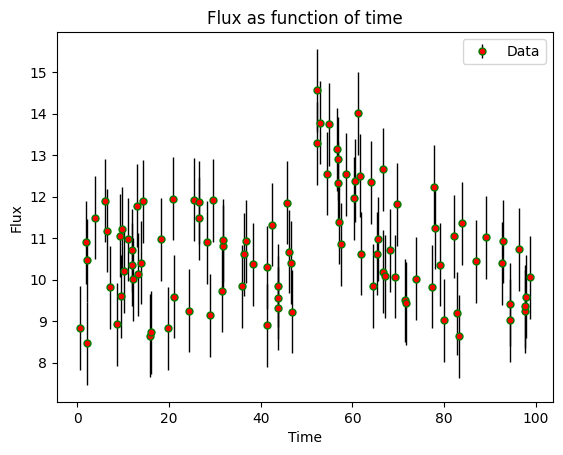

In [ ]:
data = np.load('transient.npy').T
plt.errorbar(data[0], data[1], yerr=data[2], color='black', linewidth=1, linestyle='none', marker='o', mfc='red',mec='green', ms=5, mew=1, label='Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Flux as function of time')
plt.legend()

In [ ]:
def fit_model(t,b,A,alpha,t_0):
    return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))

def log_likelihood(p, x, y, yerr):
    t_0, A, ln_alpha, b = p #the model parmeters we are looking for
    model = fit_model(x,b,A,np.exp(ln_alpha),t_0) #the model will be compere to the data
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2)

def log_prior(p):
    t_0, A, ln_alpha, b = p #the model parmeters we are looking for
    if  0<t_0<100and 0<A<50 and -5<ln_alpha<5 and 0<b<50:
        return 0.0
    return -np.inf

def lnprob(p, x, y, yerr):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p, x,y,yerr)

def main(p0, nwalkers, nsteps, ndim, lnprob, x, y, yerr):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps, progress=True, store=True)

    return sampler, pos, prob, state



In [ ]:
ndim = 4
nwalkers=150
nsteps = 10000
initial=np.array([50,10,0.1,7])

p0 = [np.array(initial) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler, pos, prob, state = main(p0 ,nwalkers, nsteps, ndim, lnprob, data[0], data[1], data[2])
samples = sampler.flatchain


Running burn-in...


 23%|██▎       | 23/100 [00:00<00:01, 70.87it/s]<ipython-input-6-6229b1e76470>:2: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
<ipython-input-6-6229b1e76470>:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
100%|██████████| 100/100 [00:01<00:00, 64.91it/s]


Running production...


100%|██████████| 10000/10000 [01:25<00:00, 117.23it/s]


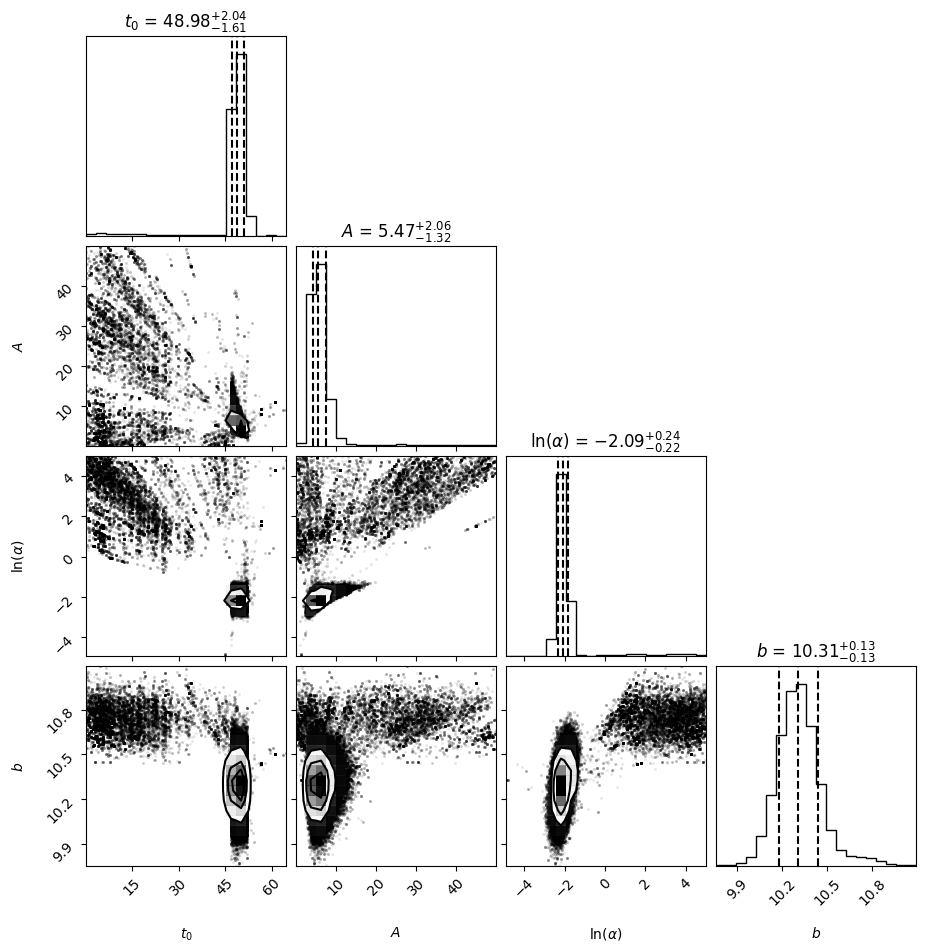

In [ ]:
labels = [r'$t_0$', r'$A$', r'$\ln(\alpha)$', r'$b$']
fig = corner.corner(samples, labels=labels, show_titles=True,plot_datapoints=True ,quantiles=[0.16, 0.5, 0.84],lavels=(0.68,0.95))
fig.show()

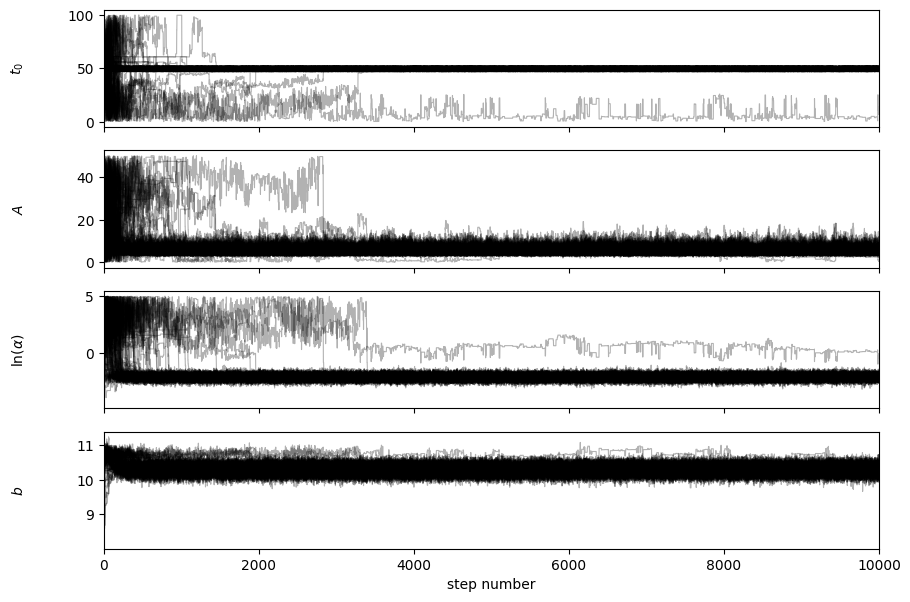

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_ = sampler.get_chain()
for i in range(ndim):
  ax = axes[i]
  ax.plot((samples_[:, :, i]), "k", alpha=0.3, linewidth=0.8)
  ax.set_xlim(0, len(samples_))
  ax.set_ylabel(labels[i])
  ax.yaxis.set_label_coords(-0.1, 0.5)

  axes[-1].set_xlabel("step number");
plt.show()

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: ignored

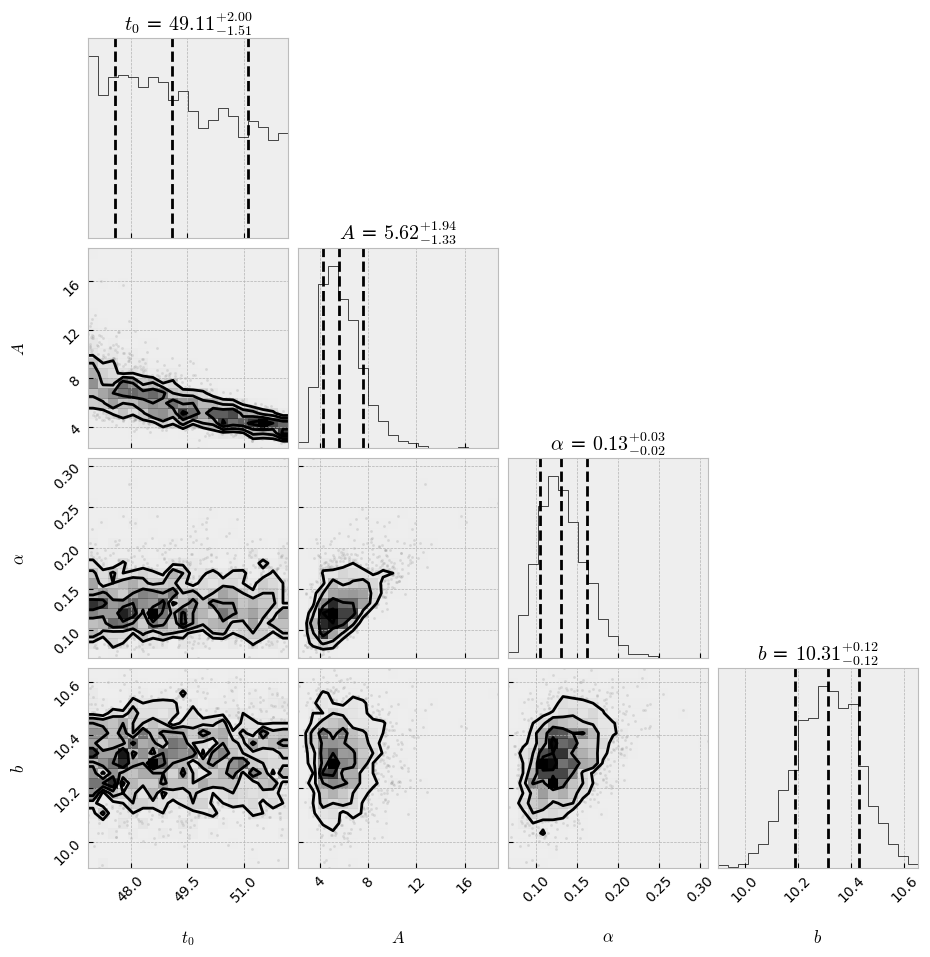

In [ ]:
flat_samples = sampler.get_chain(thin=80, flat=True)
fig = corner.corner(flat_samples, labels=labels, show_titles=True,plot_datapoints=True ,quantiles=[0.16, 0.5, 0.84])
fig.show()


In [ ]:
random_samples = flat_samples[np.random.choice(len(flat_samples),size=100)]

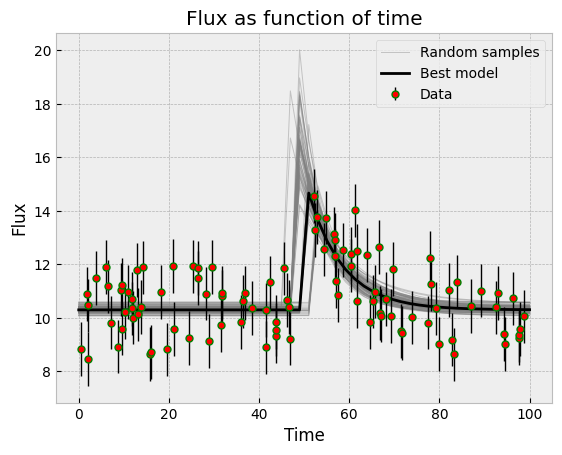

In [ ]:
x = np.linspace(0,100)
for sample in random_samples:
  t_0, A, alpha, b = sample
  plt.plot(x,fit_model(x,b,A,alpha,t_0), color='grey', alpha=0.4, linewidth=0.7)

t_0, A, alpha, b = random_samples[0]
plt.plot(x,fit_model(x,b,A,alpha,t_0),label='Random samples', color='grey',  alpha=0.4, linewidth=0.7)
plt.plot(x, fit_model(x,10.3,5.63,0.13,49.06), label='Best model', color='black')
plt.errorbar(data[0], data[1], yerr=data[2], color='black', linewidth=1, linestyle='none', marker='o', mfc='red',mec='green', ms=5, mew=1, label='Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Flux as function of time')
plt.legend()

In [ ]:

parmeters = [np.percentile(flat_samples[:,i],[5,50,95]) for i in range(4)]
labels = ['t_0', 'A', 'alpha', 'b']

for par, l in zip(parmeters,labels):
  print(f'{l} =\t {round(par[1],2)}\t + {round(par[2]-par[1],2)}\t - {round(par[1]-par[0],2)}\n')


t_0 =	 49.11	 + 2.7	 - 2.04

A =	 5.62	 + 3.64	 - 1.9

alpha =	 0.13	 + 0.06	 - 0.04

b =	 10.31	 + 0.19	 - 0.2



## Exercise 3: Back to the Transient Universe<a class="anchor" id="five"></a>

In [ ]:
# Define the dimensionality of our problem.
ndim = 4

def loglike(p, x, y, yerr):
    A,b,t_0,alpha=p
    y_fit = fit_model(x,b,A,alpha,t_0)
    return -0.5 * np.sum((y-y_fit)**2 / yerr**2 )


def ptform(u):
    x = np.array(u)  # copy u
    x[0] = stats.uniform(loc=0,scale=50).ppf(u[0])
    x[1] = stats.uniform(loc=0,scale=50).ppf(u[1])
    x[2] = stats.uniform(loc=0,scale=100).ppf(u[2])
    x[3] = stats.loguniform.ppf(u[3],np.exp(-5),np.exp(5))
    return x



In [ ]:
sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data[0],data[1],data[2]])
sampler.run_nested()
sresults = sampler.results



<ipython-input-15-67dbd632166a>:2: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
<ipython-input-15-67dbd632166a>:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1807it [00:50, 13.34it/s, bound: 0 | nc: 77 | ncall: 18043 | eff(%): 10.015 | loglstar:   -inf < -177.401 <    inf | logz: -185.919 +/-  0.121 | dlogz: 102.989 >  0.509]<ipython-input-15-67dbd632166a>:2: RuntimeWarning: overflow encountered in exp
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1830it [00:51, 31.53it/s, bound: 1 | nc: 16 | ncall: 18310 | eff(%):  9.995 | loglstar:   -inf < -172.034 <    inf | logz: -180.389 +/-  0.122 | dlogz: 97.390 >  0.509]<ipython-input-15-67dbd632166a>:2: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t_0,b,b+A*np.exp(-alpha*(t-t_0)))
1970it [00:52, 82.63it/s, bound: 1 | nc: 4 | ncall: 18937 | eff(%): 10.403 | loglstar:   -inf < -140.626 <    inf | logz:

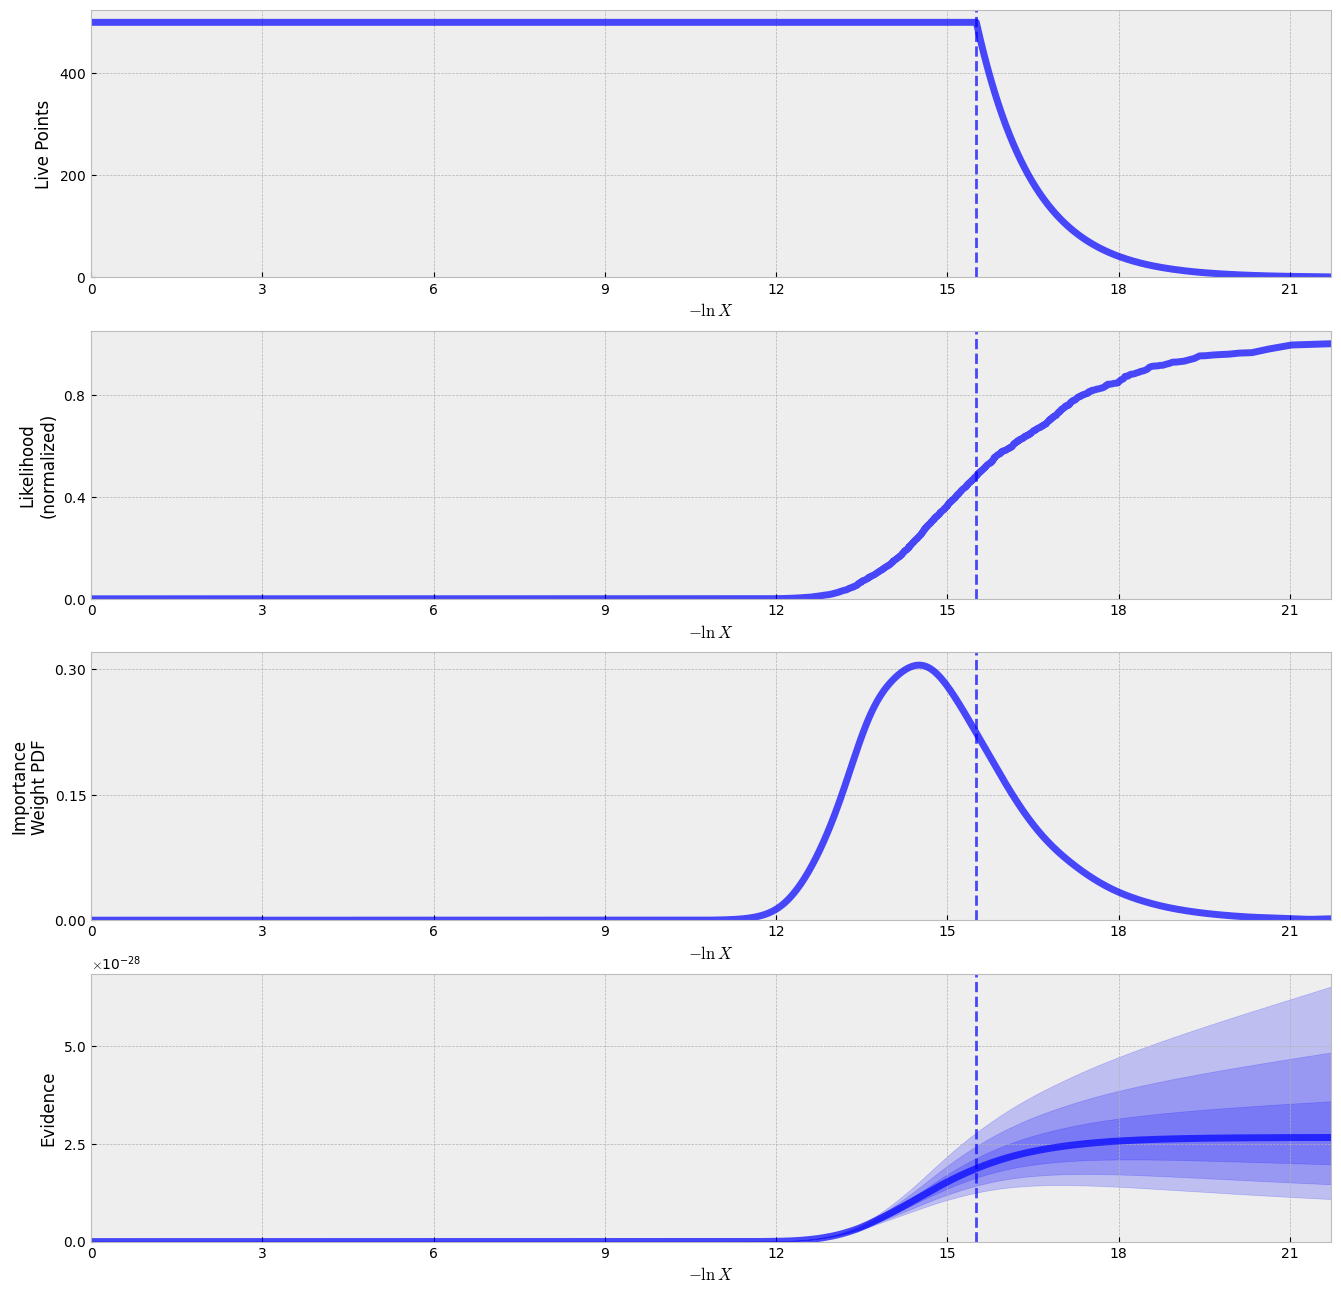

In [ ]:
rfig, raxes = dyplot.runplot(sresults)

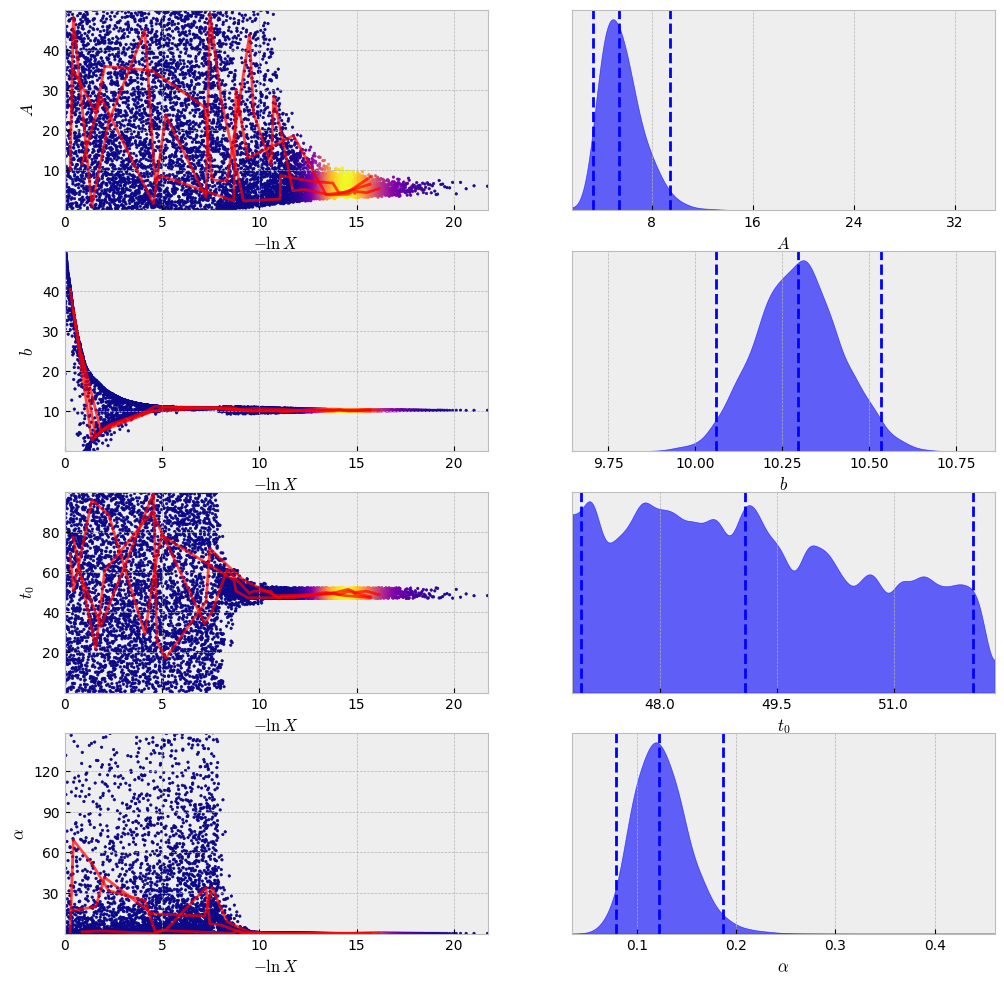

In [ ]:
labels = [r'$A$',r'$b$',r'$t_0$',r'$\alpha$']

tfig, taxes = dyplot.traceplot(sresults,truth_color='black',connect=True,connect_highlight=range(3),labels=labels)

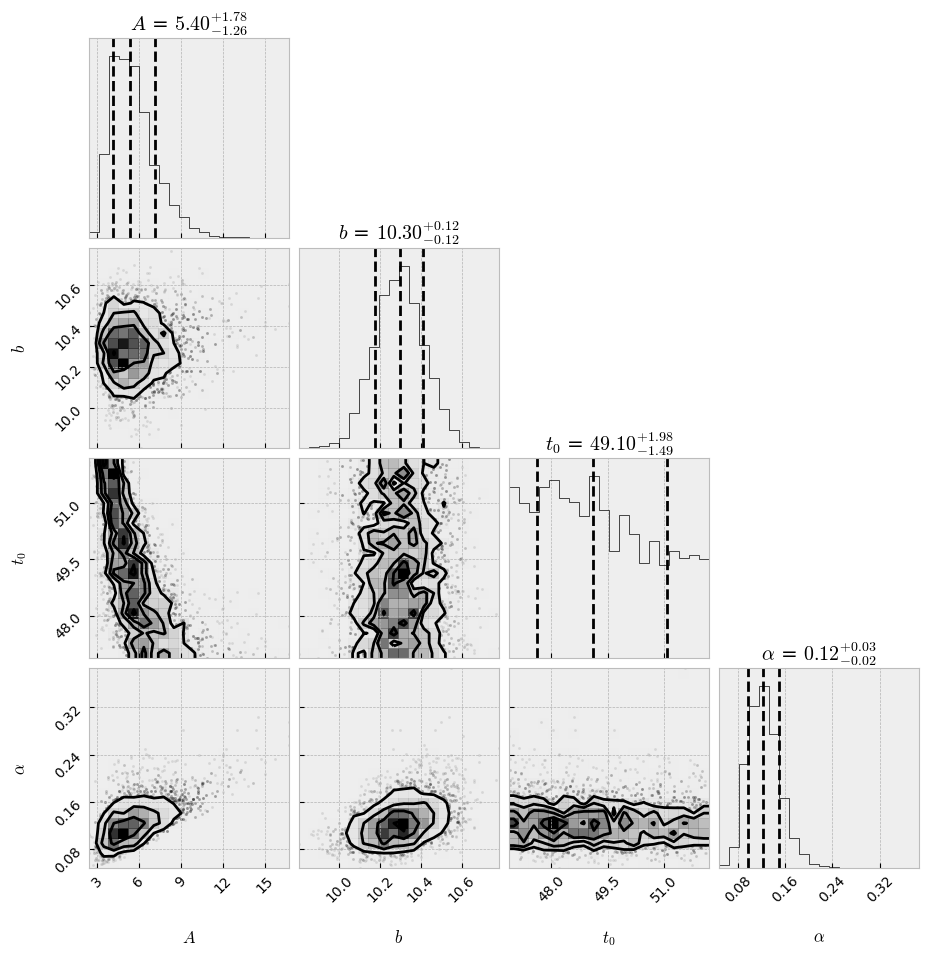

In [ ]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels,show_titles=True,plot_datapoints=True ,quantiles=[0.16, 0.5, 0.84]);

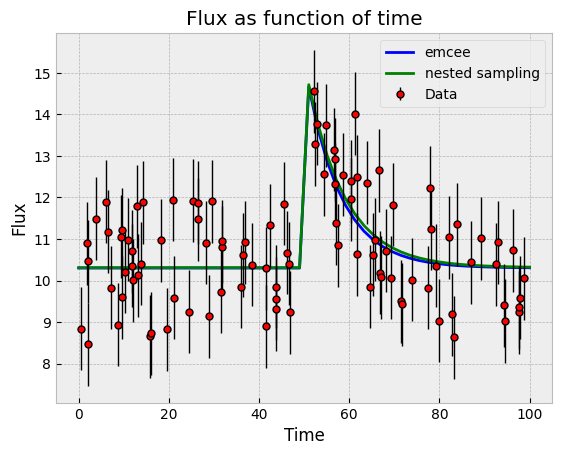

In [ ]:
x = np.linspace(0,100)
plt.plot(x, fit_model(x,10.3,5.63,0.13,49.06), label='emcee', color='blue', ls='-')
plt.plot(x, fit_model(x,10.31,5.59,0.12,49.04), label='nested sampling', color='green', ls='-')
plt.errorbar(data[0], data[1], yerr=data[2], color='black', linewidth=1, linestyle='none', marker='o', mfc='red', ms=5, mew=1, label='Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Flux as function of time')
plt.legend()

In [ ]:
burst_evidence = sresults.logz[-1] #evidence

parmeters = [np.percentile(samples[:,i],[5,50,95]) for i in range(4)]
labels = ['t_0', 'A', 'alpha', 'b']

for par, l in zip(parmeters,labels):
  print(f'{l} =\t {round(par[1],2)}\t + {round(par[2]-par[1],2)}\t - {round(par[1]-par[0],2)}\n')

t_0 =	 8.89	 + 35.12	 - 7.0

A =	 10.5	 + 13.26	 - 2.89

alpha =	 49.19	 + 41.35	 - 38.09

b =	 0.35	 + 81.41	 - 0.31



In [ ]:
def gaussian(t,t_0,A,b,sigma):
    return b+A*np.exp(-(t-t_0)**2/2/sigma**2)

def loglike(p, x, y, yerr):
    A,b,t_0,sigma=p
    y_fit = gaussian(x,t_0,A,b,sigma)
    return -0.5 * np.sum((y-y_fit)**2 / yerr**2 )


def ptform(u):
    x = np.array(u)  # copy u
    x[0] = stats.uniform(loc=0,scale=50).ppf(u[0])
    x[1] = stats.uniform(loc=0,scale=50).ppf(u[1])
    x[2] = stats.uniform(loc=0,scale=100).ppf(u[2])
    x[3] = stats.loguniform.ppf(u[3],np.exp(-5),np.exp(5))
    return x


In [ ]:

sampler = dynesty.NestedSampler(loglike, ptform, ndim,logl_args=[data[0],data[1],data[2]],nlive=100)
sampler.run_nested()
sresults = sampler.results

1812it [06:26,  4.69it/s, +100 | bound: 861 | nc: 1 | ncall: 142139 | eff(%):  1.346 | loglstar:   -inf < -52.439 <    inf | logz: -68.225 +/-  0.374 | dlogz:  0.001 >  0.109]


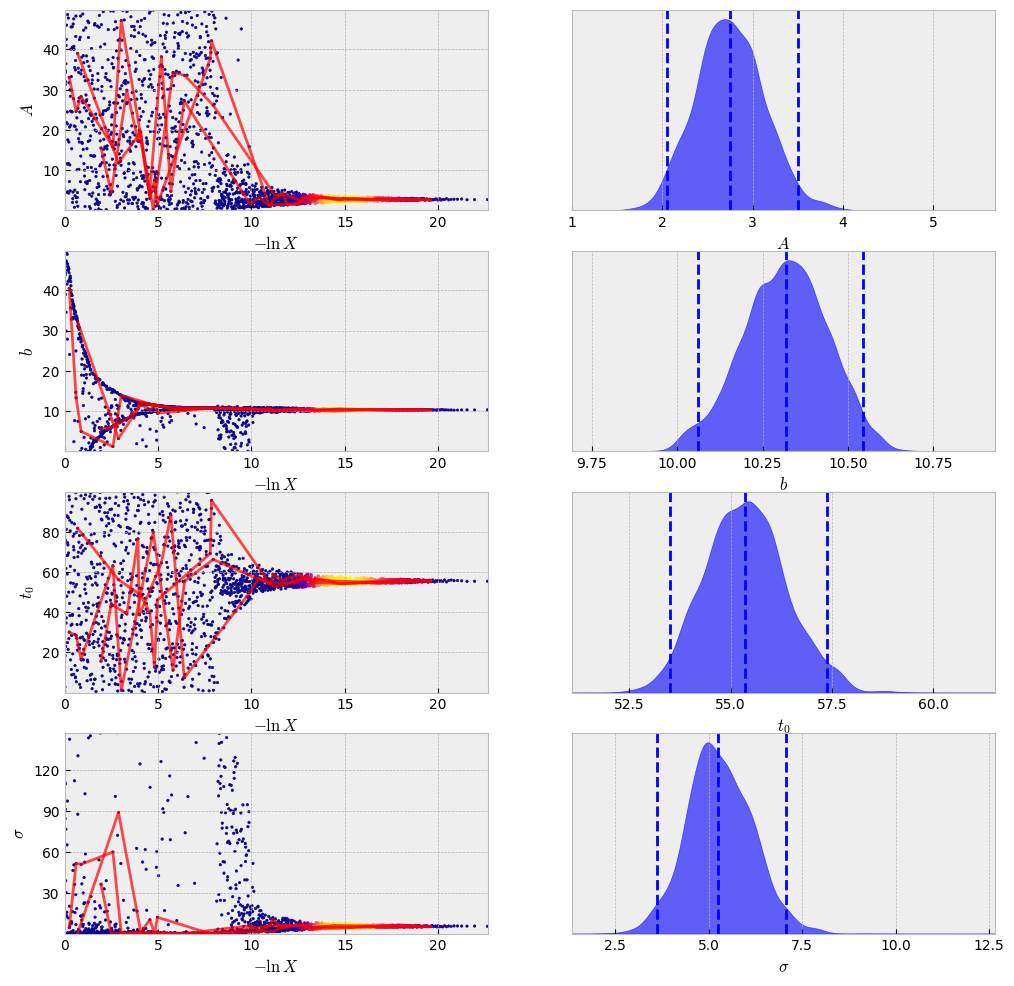

In [ ]:
labels = [r'$A$',r'$b$',r'$t_0$',r'$\sigma$']

tfig, taxes = dyplot.traceplot(sresults,truth_color='black',connect=True,connect_highlight=range(3),labels=labels)

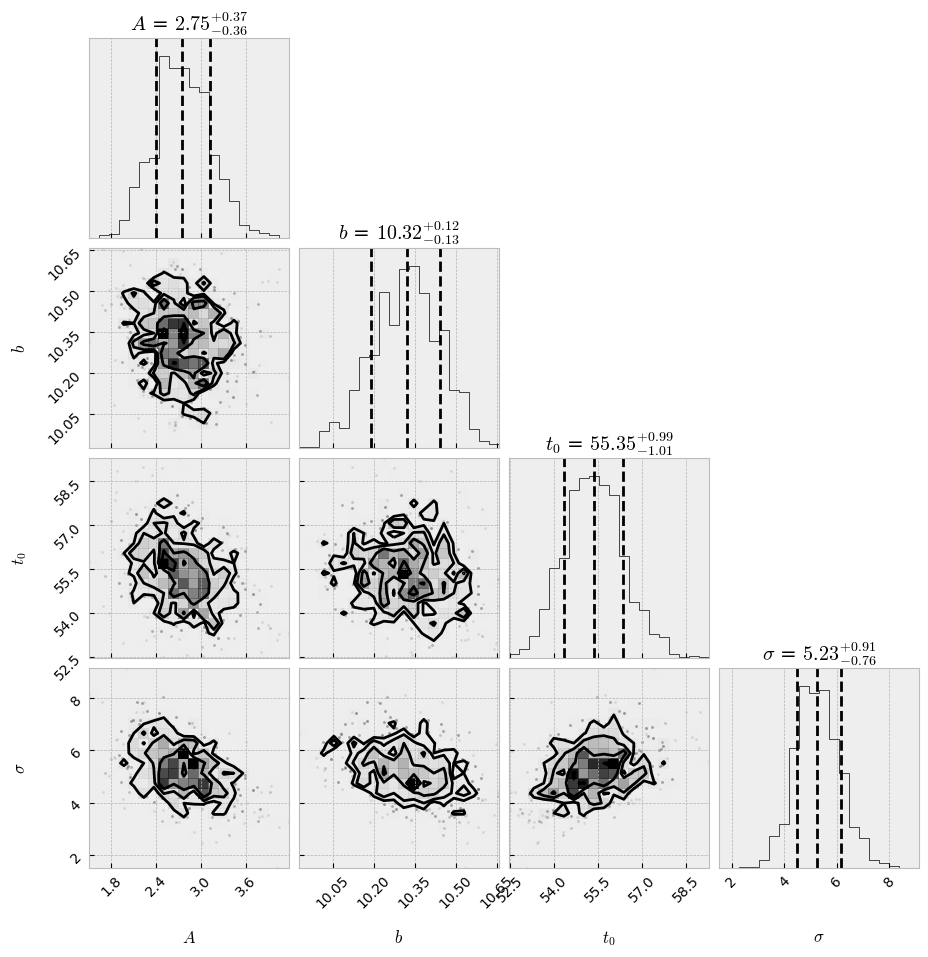

In [ ]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=labels,show_titles=True,plot_datapoints=True ,quantiles=[0.16, 0.5, 0.84]);

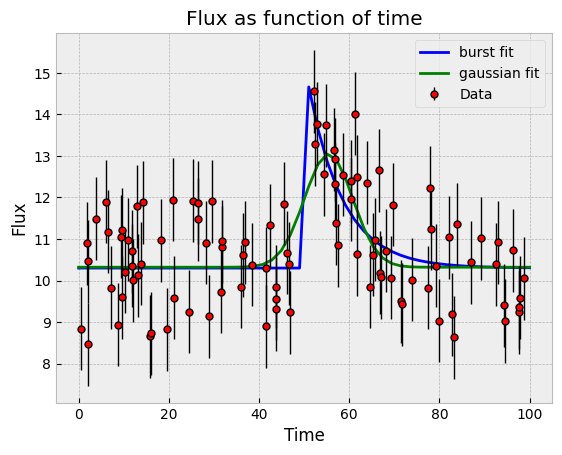

In [ ]:
x = np.linspace(0,100)
plt.plot(x, fit_model(x,10.3,5.63,0.13,49.06), label='burst fit', color='blue', ls='-')
plt.plot(x, gaussian(x,55.42,2.73,10.32,5.36), label='gaussian fit', color='green', ls='-')
plt.errorbar(data[0], data[1], yerr=data[2], color='black', linewidth=1, linestyle='none', marker='o', mfc='red', ms=5, mew=1, label='Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Flux as function of time')
plt.legend()

In [ ]:
labels = ['A','b','t_0','sigma']

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]

for par,l in zip(quantiles,labels):
  print(str(l)+': 68% parameter credible regions are:\n ' + str(par) + '\n')

A: 68% parameter credible regions are:
 [2.3929270570870034, 3.114121281380097]

b: 68% parameter credible regions are:
 [10.190754590267247, 10.444325283740202]

t_0: 68% parameter credible regions are:
 [54.35086723416216, 56.352836132801286]

sigma: 68% parameter credible regions are:
 [4.481297796452931, 6.163334042148514]



In [ ]:
gauss_evidence = sresults.logz[-1] #evidence
print("Bayesian evidence for gaussian fit is", np.exp(gauss_evidence))
print("Bayesian evidence for burst fit is", np.exp(burst_evidence))

Bayesian evidence for gaussian fit is 2.3458096741081256e-30
Bayesian evidence for burst fit is 2.656373341371054e-28
